In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
master_df = pd.read_csv("new_calculated_value_class_division_coils.csv")

In [3]:
# Identify features: all columns ending with '_calculated_value'
feature_cols = [col for col in master_df.columns if col != 'Coil ID']

# Remove any column where ALL values are 0 or ALL are -99.99
drop_cols = []
for col in feature_cols:
    col_values = master_df[col].values
    if np.all(col_values == 0) or np.all(col_values == -99.99):
        drop_cols.append(col)

# Actually drop those columns
x_features = [col for col in feature_cols if col not in drop_cols]
print("Dropped columns:", drop_cols)
print("Remaining features for modeling:", x_features)

Dropped columns: ['S4 Operating Bending Trim_filtered_mean', 'Stand 4 Gap Bite Offset_filtered_mean', 'Stand 4 Gap Thread Offset_filtered_mean']
Remaining features for modeling: ['X4 Gauge Deviation_filtered_mean', 'Stand 1 Gap Operator Offset_filtered_mean', 'Stand 2 Gap Operator Offset_filtered_mean', 'Stand 3 Gap Operator Offset_filtered_mean', 'Stand 4 Gap Operator Offset_filtered_mean', 'S1 Operating Bending Trim_filtered_mean', 'S2 Operating Bending Trim_filtered_mean', 'S3 Operating Bending Trim_filtered_mean', 'X0 Gauge Deviation_filtered_mean', 'X1 Gauge Deviation_filtered_mean', 'Stand 1-2 Tension Reference_filtered_mean', 'Stand 2-3 Tension Reference_filtered_mean', 'Stand 3-4 Tension Reference_filtered_mean', 'Stand 1-2 Total Tension Feedback_filtered_mean', 'Stand 2-3 Total Tension Feedback_filtered_mean', 'Stand 3-4 Total Tension Feedback_filtered_mean', 'Exit Tension Reel Tension Reference_filtered_mean', 'Tension Reel Calculated Tension_filtered_mean', 'Stand 1 Gap Bite

In [4]:
# Find classes with o<=5 sample
vc = master_df['class_string'].value_counts()
rare_classes = vc[vc <= 15].index

print("Classes with <=15 sample:", list(rare_classes))
# Remove them
df_filtered = master_df[~master_df['class_string'].isin(rare_classes)].copy()
print("Filtered dataframe shape:", df_filtered.shape)

Classes with <=15 sample: ['HMMMH', 'MMLLL', 'LLLMM', 'MLMMH', 'HLMMM', 'HMMHH', 'LLMMM', 'MHMMM', 'MMLHM', 'HLMLM', 'MLLMH', 'LMLMM', 'LLMLM', 'MMHMM', 'LLLML', 'HMLLM', 'MLLLH', 'LLMLL', 'HMMLM', 'HMLMH', 'LMMMM', 'MHLMM', 'MMMLL', 'MLHLM', 'LMLML', 'HMMHM', 'MLMHM', 'MMMLH', 'LMLLL', 'MLHMM', 'MLMLH', 'MMLMH', 'HMHMH', 'HLMHM', 'HLMLL', 'HLLML', 'HLLMH', 'MMMHH', 'HLLLL', 'HMHMM', 'HLHMM', 'HMLML', 'MHLHM', 'HLMMH', 'MLLHM', 'HHMMM', 'MLMHH', 'HLMML', 'LMMML', 'LMMLL', 'HLMLH', 'MMHMH', 'HHMHH', 'HHHHH', 'MLHMH', 'MMHLM', 'HHLMM', 'MMLLH', 'HLMHH', 'HHLHM', 'LLHML', 'MHMHM', 'HMHML', 'MMHML', 'HMMML', 'LLLLH', 'LMLHM', 'LMMHL', 'HHMHM', 'MMLHH', 'HHMMH', 'MLHLH', 'HMLHM', 'LLMML', 'HMMLH', 'HLLLH', 'LMMLM', 'HLHLM', 'LHLMM', 'HHMLH', 'HHLLH', 'HHLLM', 'LHHLM', 'MLHLL', 'MHLLM', 'MHHHM', 'HLHLH', 'MMHHM', 'HMHLM', 'LMMHM', 'LHLML', 'MMMHL', 'HHHMM', 'MHLHH', 'MHMMH']
Filtered dataframe shape: (2555, 135)


In [6]:
vc

class_string
MLLLM    416
MMMMM    308
MLLMM    305
MMLMM    210
MLMMM    158
        ... 
LHLML      1
MMMHL      1
HHHMM      1
MHLHH      1
MHMMH      1
Name: count, Length: 118, dtype: int64

In [27]:
df_filtered['class_string'].value_counts()

class_string
MLLLM    416
MMMMM    308
MLLMM    305
MMLMM    210
MLMMM    158
MMLLM    144
MLLLL    102
MLMLM    102
HMMMM     65
MMMLM     59
LLLLM     53
MLLML     47
MMLML     37
LLLLL     37
MMMML     28
MMMHM     27
HLLLM     26
MLMLL     23
MLMML     22
HMLMM     21
MMMMH     21
HLLMM     20
LMLLM     19
Name: count, dtype: int64

In [5]:
df_filtered.dropna(inplace=True)
X = df_filtered[x_features].drop(['class_string'],axis=1)
y = df_filtered['class_string']

# Encode y (because it's a string like "HHLHL"), use sklearn's LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test (70/30 split, random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [16]:
print(X.shape)

(2555, 132)


In [17]:
print(y.shape)

(2555,)


In [18]:
np.unique(y_train,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([ 18,  14,  15,  46,  26,  37,  13,  71, 291,  33, 213,  16,  71,
         15, 111, 101,  26, 147,  19,  41,  15,  20, 216, 213]))

In [19]:
np.unique(y_test,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([  8,   6,   6,  19,  11,  16,   6,  31, 125,  14,  92,   7,  31,
          7,  47,  43,  11,  63,   8,  18,   6,   8,  92,  92]))

In [21]:
y_test

array([23, 22, 22, 23, 21, 17, 18, 15, 10, 15, 14, 23, 23,  3, 22,  3, 10,
       17, 20,  7, 17, 23, 12, 23, 17,  9,  8, 15, 22, 12,  3,  8, 17, 22,
        3,  8, 23, 10,  0,  3,  8, 10, 23, 12, 22, 13, 23, 10, 10,  9, 19,
       23, 23, 23, 20, 17, 15, 10, 10,  7, 23, 19,  8,  8, 23, 14, 12, 17,
       10,  8, 15, 10, 19, 23,  6, 22, 23,  8, 15, 22,  8, 17, 14, 22, 23,
       15, 15,  8, 10, 14, 22, 17, 21,  9, 17, 10, 22,  9, 21, 15, 10, 10,
       19, 17, 14,  7, 12, 15, 22,  8, 15,  7, 22,  8,  7, 12, 10,  8, 23,
        8,  3, 14, 14, 14,  8, 13, 14,  8, 22, 22, 22,  7, 23,  1,  8, 14,
        5, 22,  8, 23,  7, 15,  1, 14,  4, 10, 17,  3,  8, 13, 23,  8,  8,
       22, 17,  0, 23, 23,  7, 12, 20, 10, 17, 19, 22,  9, 22,  8, 18, 10,
       16, 12, 10, 22, 23, 12, 19,  6, 10,  8, 23, 10,  9,  2, 23,  8, 10,
        7, 12, 22,  3,  5, 16, 22, 17,  7, 22, 22,  8, 10,  4, 10, 22, 22,
        1,  8,  5, 16, 10, 10,  8,  7, 23, 17, 17,  8,  9,  3, 23,  8, 17,
       17, 22, 23,  8, 10

In [23]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [31]:
X_train

,X4 Gauge Deviation_filtered_mean,Stand 1 Gap Operator Offset_filtered_mean,Stand 2 Gap Operator Offset_filtered_mean,Stand 3 Gap Operator Offset_filtered_mean,Stand 4 Gap Operator Offset_filtered_mean,S1 Operating Bending Trim_filtered_mean,S2 Operating Bending Trim_filtered_mean,S3 Operating Bending Trim_filtered_mean,X0 Gauge Deviation_filtered_mean,X1 Gauge Deviation_filtered_mean,...,Stand 3 OS Roll Force_filtered_mean,Stand 4 OS Roll Force_filtered_mean,Stand 1 DS Roll Force_filtered_mean,Stand 2 DS Roll Force_filtered_mean,Stand 3 DS Roll Force_filtered_mean,Stand 4 DS Roll Force_filtered_mean,Roll Force Hydraulics Pressure Feedback_filtered_mean,Stand 1 Roll Force_filtered_mean,Stand 1 Roll Force limit (g67 delayed 200 ms + g80)_filtered_mean,Stand 1 Roll Force Increase Limit (based on predicted run force)_filtered_mean
1202,-0.002720,0.0,0.0,0.0,0.0,-48.000000,0.000000,0.000000,0.709244,0.040791,...,684.920334,474.370193,633.515673,671.951383,703.157621,461.307368,2989.144369,1252.657915,1400.731078,148.244494
247,-0.020003,0.0,0.0,0.0,0.0,-72.000000,0.000000,0.000000,-1.501766,-0.070876,...,598.849492,631.888694,712.071726,667.804594,606.889978,619.892252,3055.372286,1418.973378,1571.766991,161.820000
1799,0.116452,0.0,0.0,0.0,0.0,0.000000,-60.799988,-20.799988,-0.397461,0.039495,...,507.279979,350.204008,650.840989,547.871122,533.312445,337.911548,3001.700776,1283.228260,1411.369505,120.024793
2135,0.106883,0.0,0.0,0.0,0.0,-60.799988,0.000000,0.000000,-0.161231,0.095710,...,485.897153,444.989264,665.505691,569.208882,505.862238,419.945384,3033.090284,1304.986750,1593.010271,299.931387
2889,-0.021694,0.0,0.0,0.0,0.0,-64.000000,-144.000000,0.000000,-0.120532,-0.086788,...,616.456710,673.092020,710.165470,687.327089,625.880496,623.628483,3049.740558,1400.958149,1556.476825,145.036206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,-0.013407,0.0,0.0,0.0,0.0,51.200012,51.200012,0.000000,-0.021104,0.029138,...,470.026268,438.351639,656.941465,513.200668,507.850995,418.959811,3005.750359,1277.894969,1417.148092,144.715770
1567,0.069806,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.187049,0.087258,...,541.147936,466.266081,620.368427,623.187363,561.070560,422.273286,2995.285803,1237.496711,1384.270424,147.242576
2949,0.017660,0.0,0.0,0.0,0.0,57.600006,0.000000,-1.600006,-0.343803,-0.072987,...,463.795525,412.639674,634.730564,541.247492,490.019345,391.721089,3023.558044,1264.682242,1421.347003,146.019740
1718,0.263059,0.0,0.0,0.0,0.0,0.000000,-22.399994,12.799988,0.440141,-0.077566,...,433.811122,292.466616,541.553935,491.896054,463.975340,278.749593,3033.211301,1055.719382,1190.183158,135.574793


## SVC

In [6]:
svc = SVC(
    C=1.0,                   
    kernel='rbf',            
    degree=3,                
    gamma='scale',           
    probability=False, 
    random_state=42
)
clfsvc = OneVsRestClassifier(svc)

clfsvc.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

In [8]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Use a smaller subset of test data for faster computation
subset_size = 100  # Adjust based on your data size and speed
X_test_subset = X_test.iloc[:subset_size]
y_test_subset = y_test[:subset_size]

# Compute permutation importance with fewer repeats for speed
result = permutation_importance(
    clfsvc,                 # your trained OneVsRestClassifier wrapping SVC
    X_test_subset,
    y_test_subset,
    n_repeats=3,            # fewer repeats for faster results
    random_state=42,
    n_jobs=-1               # use all CPUs, remove if it causes issues
)

# Create a DataFrame with feature names and their average importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
})

# Sort features by importance descending and get top 20
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(20)

print(top_20_features)

                                           feature  importance
47   Stand 2 Bottom Current Feedback_filtered_mean    0.083333
43      Stand 2 Top Current Feedback_filtered_mean    0.066667
67      Stand 3 Drive Speed Feedback_filtered_mean    0.066667
38       Stand 3 Predicted Run Force_filtered_mean    0.053333
68      Stand 4 Drive Speed Feedback_filtered_mean    0.053333
26       Stand 2 Thread Gap Setpoint_filtered_mean    0.036667
65      Stand 1 Drive Speed Feedback_filtered_mean    0.036667
59     Stand 2 - Operator Side Force_filtered_mean    0.033333
49   Stand 4 Bottom Current Feedback_filtered_mean    0.033333
60        Stand 2 - Drive Side Force_filtered_mean    0.033333
45      Stand 4 Top Current Feedback_filtered_mean    0.026667
44      Stand 3 Top Current Feedback_filtered_mean    0.026667
36       Stand 1 Predicted Run Force_filtered_mean    0.026667
124            Stand 3 DS Roll Force_filtered_mean    0.023333
102         Stand 3 Bottom Motor RPM_filtered_mean    0

In [10]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Use a smaller subset of the test data for faster computation
subset_size = 100  # Adjust as needed
X_test_subset = X_test.iloc[:subset_size]
y_test_subset = y_test[:subset_size]

# Compute permutation importance with fewer repeats to speed up
result = permutation_importance(
    clfsvc,                 # your trained OneVsRestClassifier with SVC
    X_test_subset,
    y_test_subset,
    n_repeats=3,            # lower repeats for performance
    random_state=42,
    n_jobs=-1               # use all CPUs, modify if needed
)

# Create a DataFrame of feature names and their mean importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
})

# Normalize importances to 0-100% scale
importance_df['importance_percent'] = (importance_df['importance'] / importance_df['importance'].max()) * 100

# Sort features by importance descending and take top 20
top_20_features = importance_df.sort_values(by='importance_percent', ascending=False).head(20)

print(top_20_features[['feature', 'importance_percent']])


                                           feature  importance_percent
47   Stand 2 Bottom Current Feedback_filtered_mean               100.0
43      Stand 2 Top Current Feedback_filtered_mean                80.0
67      Stand 3 Drive Speed Feedback_filtered_mean                80.0
38       Stand 3 Predicted Run Force_filtered_mean                64.0
68      Stand 4 Drive Speed Feedback_filtered_mean                64.0
26       Stand 2 Thread Gap Setpoint_filtered_mean                44.0
65      Stand 1 Drive Speed Feedback_filtered_mean                44.0
59     Stand 2 - Operator Side Force_filtered_mean                40.0
49   Stand 4 Bottom Current Feedback_filtered_mean                40.0
60        Stand 2 - Drive Side Force_filtered_mean                40.0
45      Stand 4 Top Current Feedback_filtered_mean                32.0
44      Stand 3 Top Current Feedback_filtered_mean                32.0
36       Stand 1 Predicted Run Force_filtered_mean                32.0
107   

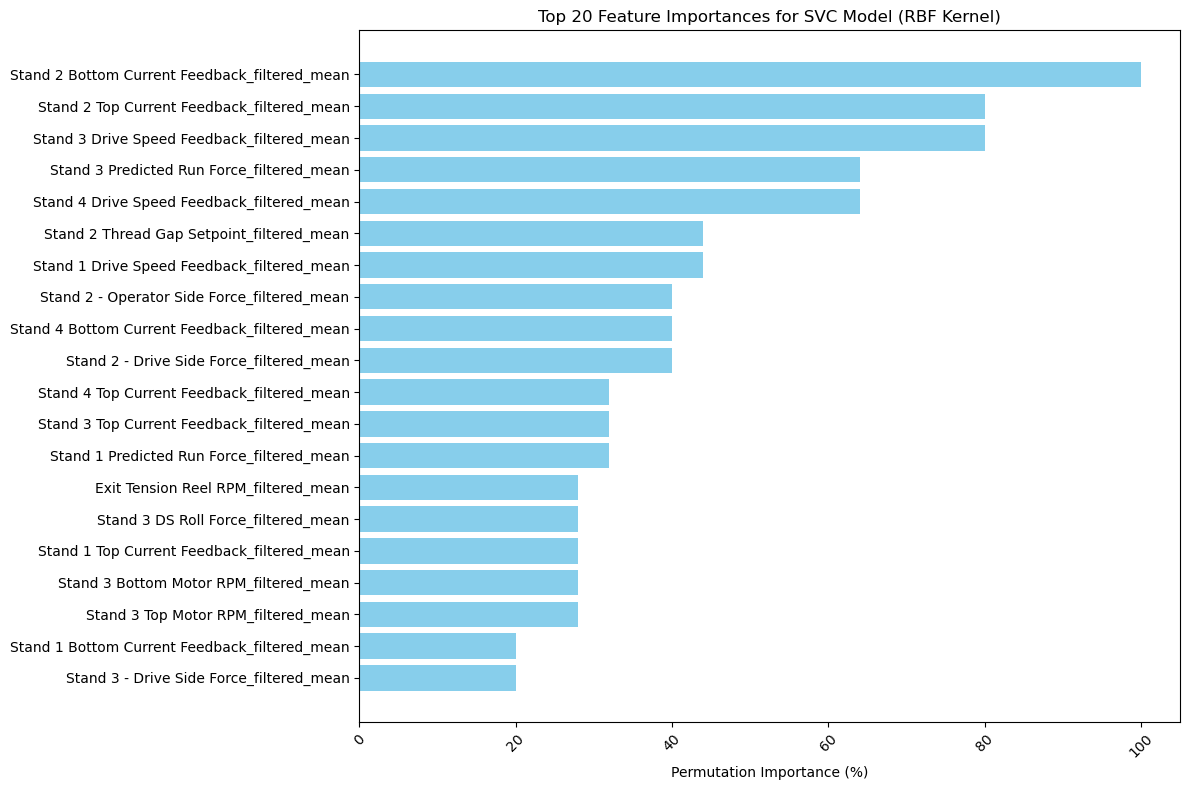

In [11]:
import matplotlib.pyplot as plt

# Assuming `top_20_features` is a DataFrame with columns ['feature', 'importance_percent']

plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance_percent'], color='skyblue')
plt.xlabel('Permutation Importance (%)')
plt.title('Top 20 Feature Importances for SVC Model (RBF Kernel)')
plt.gca().invert_yaxis()  # So the most important feature is at the top
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## XGBoost

In [12]:
# XGBoost can handle multiclass natively
clf = XGBClassifier(
    n_estimators=113,
    max_depth=3,
    learning_rate=0.13312820438128978,
    subsample=0.9173953855049505,
    colsample_bytree=0.6093189324139895,
    gamma=0.780254120577378,
    reg_alpha=0.6574622292293312,   # alpha → reg_alpha
    reg_lambda=4.418421467097197,   # lambda → reg_lambda
    random_state=42,
    eval_metric='mlogloss'          # Reproducibility
)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6093189324139895, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.780254120577378, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13312820438128978,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=113, n_jobs=None,
              num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

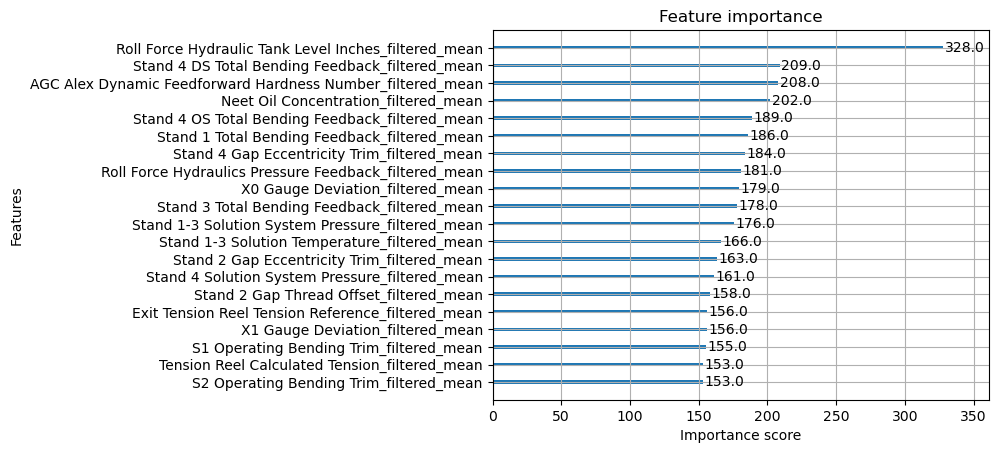

In [14]:
xgb.plot_importance(clf,max_num_features=20)

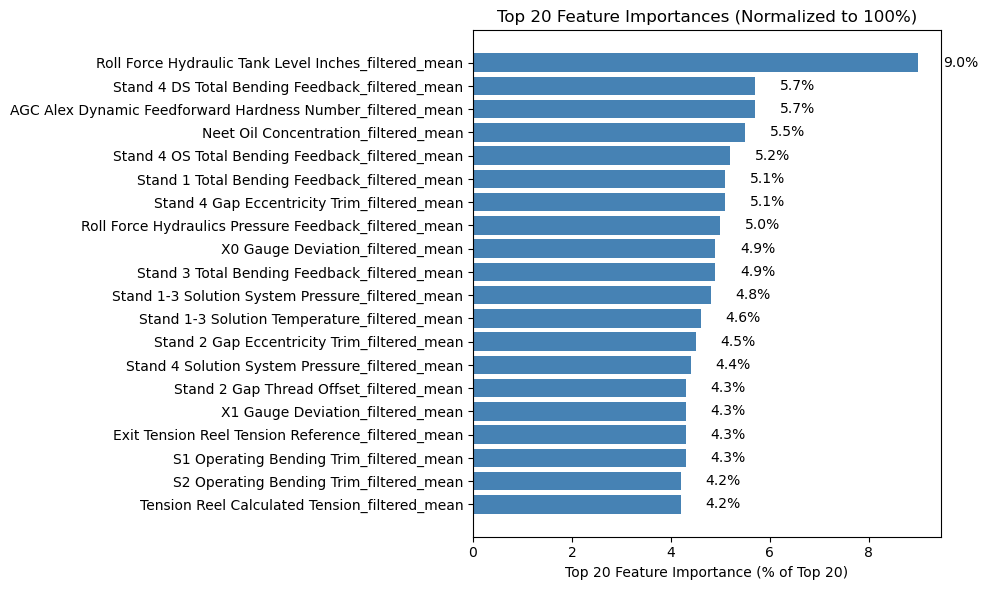

In [16]:
df_top20 = df_imp.sort_values(by='Importance', ascending=False).head(20).copy()

# Step 1: Raw importance, as before
raw_importance = clf.get_booster().get_score(importance_type='weight')  # or 'gain', 'cover'
df_imp = pd.DataFrame.from_dict(raw_importance, orient='index', columns=['Importance'])
df_imp['Importance'] = df_imp['Importance'].astype(float)

# Step 2: Sort and select top 20
df_top20['Importance (%)'] = 100 * df_top20['Importance'] / df_top20['Importance'].sum()
# Round for display
df_top20['Importance (%)'] = df_top20['Importance (%)'].round(1)

# Adjust largest value (or last bar) so total is exactly 100%
total = df_top20['Importance (%)'].sum()
diff = 100.0 - total
if abs(diff) > 0 and len(df_top20) > 0:
    i_max = df_top20['Importance (%)'].idxmax()
    df_top20.at[i_max, 'Importance (%)'] += diff

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(df_top20.index[::-1], df_top20['Importance (%)'][::-1], color='steelblue')
for index, value in enumerate(df_top20['Importance (%)'][::-1]):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center')
plt.xlabel("Top 20 Feature Importance (% of Top 20)")
plt.title("Top 20 Feature Importances (Normalized to 100%)")
plt.tight_layout()
plt.show()

In [11]:
y_train

array([7, 7, 7, ..., 7, 7, 7])

## Scores

In [38]:
# Predict
y_pred = clfsvc.predict(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Optional: Show full classification report for all classes
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy:  0.256
Precision: 0.265
Recall:    0.256
F1 Score:  0.254

Classification report:

              precision    recall  f1-score   support

       HLLLM       0.12      0.12      0.12         8
       HLLMM       0.11      0.17      0.13         6
       HMLMM       0.11      0.17      0.13         6
       HMMMM       0.10      0.11      0.10        19
       LLLLL       0.18      0.27      0.21        11
       LLLLM       0.18      0.12      0.15        16
       LMLLM       0.21      0.50      0.30         6
       MLLLL       0.18      0.16      0.17        31
       MLLLM       0.33      0.22      0.27       125
       MLLML       0.00      0.00      0.00        13
       MLLMM       0.38      0.30      0.33        91
       MLMLL       0.29      0.29      0.29         7
       MLMLM       0.29      0.45      0.35        31
       MLMML       0.00      0.00      0.00         7
       MLMMM       0.26      0.30      0.28        47
       MMLLM       0.28      0.26      0.2

## Seperate Classes in two classes

In [14]:
df_filtered['binary_class'] = df_filtered['class_string'].apply(
    lambda val: 0 if val == 'LLLLL' else 1
)

In [15]:
X = df_filtered[x_features]
y = df_filtered['binary_class'].values

# Encode y (because it's a string like "HHLHL"), use sklearn's LabelEncoder
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Split train/test (70/30 split, random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y_encoded)

In [16]:
# XGBoost can handle multiclass natively
clf1 = XGBClassifier(
    n_estimators=113,
    max_depth=3,
    learning_rate=0.13312820438128978,
    subsample=0.9173953855049505,
    colsample_bytree=0.6093189324139895,
    gamma=0.780254120577378,
    reg_alpha=0.6574622292293312,   # alpha → reg_alpha
    reg_lambda=4.418421467097197,   # lambda → reg_lambda
    random_state=42,
    eval_metric='mlogloss'          # Reproducibility
)
clf1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6093189324139895, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.780254120577378, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13312820438128978,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=113, n_jobs=None,
              num_parallel_tree=None, ...)

In [17]:
# Predict
y_pred = clf1.predict(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Optional: Show full classification report for all classes
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["LLLLL", "Others"]))

Accuracy:  0.839
Precision: 0.817
Recall:    0.839
F1 Score:  0.796

Classification report:

              precision    recall  f1-score   support

       LLLLL       0.85      0.98      0.91       716
      Others       0.68      0.17      0.27       154

    accuracy                           0.84       870
   macro avg       0.77      0.58      0.59       870
weighted avg       0.82      0.84      0.80       870



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

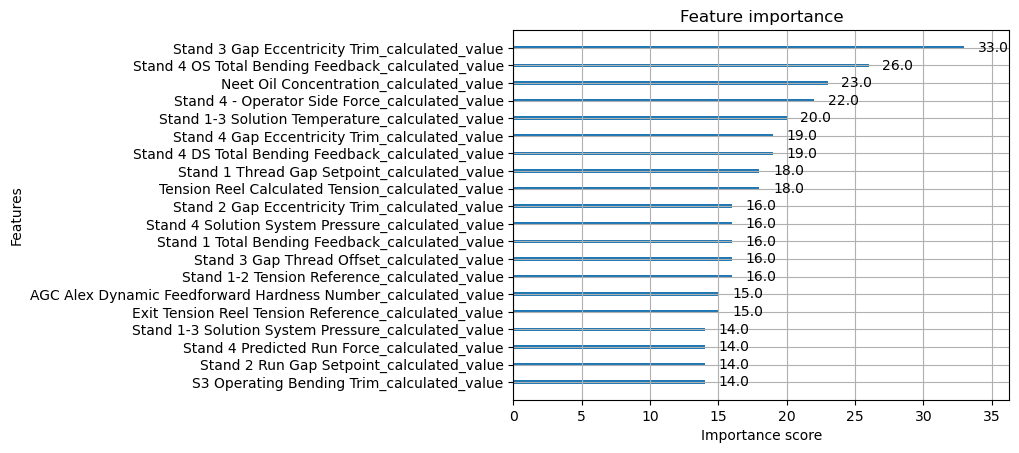

In [49]:
xgb.plot_importance(clf1,max_num_features=20)

# Classification Top - 20

In [28]:
X = df_filtered[['Neet Oil Concentration_calculated_value',
'Stand 4 DS Total Bending Feedback_calculated_value',
'Stand 4 OS Total Bending Feedback_calculated_value',
'Stand 3 Gap Eccentricity Trim_calculated_value',
'Stand 4 Top Current Feedback_calculated_value',
'Stand 2 Gap Eccentricity Trim_calculated_value',
'Stand 4 Gap Eccentricity Trim_calculated_value',
'X4 Gauge Deviation_calculated_value',
'Stand 3 Gap Thread Offset_calculated_value',
'Stand 2 Predicted Run Force_calculated_value',
'X0 Gauge Deviation_calculated_value',
'Stand 1-3 Solution Temperature_calculated_value',
'Stand 4 Predicted Run Force_calculated_value',
'Stand 4 - Operator Side Force_calculated_value',
'AGC Alex Dynamic Feedforward Hardness Number_calculated_value',
'Stand 1-3 Solution System Pressure_calculated_value',
'Stand 1 Thread Gap Setpoint_calculated_value',
'Stand 2 Gap Thread Offset_calculated_value',
'Stand 2 Total Bending Feedback_calculated_value',
'Stand 1-2 Tension Reference_calculated_value']]
y = df_filtered['class_string']

# Encode y (because it's a string like "HHLHL"), use sklearn's LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test (70/30 split, random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [29]:
# XGBoost can handle multiclass natively
clf = XGBClassifier(
    n_estimators=113,
    max_depth=3,
    learning_rate=0.13312820438128978,
    subsample=0.9173953855049505,
    colsample_bytree=0.6093189324139895,
    gamma=0.780254120577378,
    reg_alpha=0.6574622292293312,   # alpha → reg_alpha
    reg_lambda=4.418421467097197,   # lambda → reg_lambda
    random_state=42,
    eval_metric='mlogloss'          # Reproducibility
)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6093189324139895, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.780254120577378, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13312820438128978,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=113, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
# Predict
y_pred = clf.predict(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Optional: Show full classification report for all classes
print("\nClassification report taking top 20 features:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy:  0.829
Precision: 0.761
Recall:    0.829
F1 Score:  0.762

Classification report taking top 20 features:

              precision    recall  f1-score   support

       HLLHL       0.00      0.00      0.00         6
       HLLLH       0.00      0.00      0.00        13
       HLLLL       0.89      0.11      0.19        76
       LHLLL       0.00      0.00      0.00        10
       LLHLL       0.00      0.00      0.00         9
       LLLHL       0.00      0.00      0.00        16
       LLLLH       0.00      0.00      0.00        24
       LLLLL       0.83      1.00      0.91       716

    accuracy                           0.83       870
   macro avg       0.21      0.14      0.14       870
weighted avg       0.76      0.83      0.76       870



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Hyperparameter Tuning

In [13]:
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss

In [14]:
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [15]:
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': len(np.unique(y_train)),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('alpha', 0, 5),
        'reg_lambda': trial.suggest_float('lambda', 0, 5),
        'random_state': 42,
        'tree_method': 'hist'
    }

    model = XGBClassifier(**params)
    model.fit(X_subtrain, y_subtrain,
              eval_set=[(X_valid, y_valid)],
              verbose=False)

    y_pred = model.predict_proba(X_valid)
    return log_loss(y_valid, y_pred)

In [17]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=1800) 

print("Best hyperparameters:")
print(study.best_params)

[I 2025-07-29 15:11:33,588] A new study created in memory with name: no-name-cb7aa49d-e9ce-4a02-8c6f-f2c81c4b5b63
[I 2025-07-29 15:11:34,982] Trial 0 finished with value: 0.6733331283509443 and parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.13705630879308017, 'subsample': 0.7386316297175359, 'colsample_bytree': 0.9144796876729921, 'gamma': 4.073501449877906, 'alpha': 4.0795236417666185, 'lambda': 1.67796843527706}. Best is trial 0 with value: 0.6733331283509443.
[I 2025-07-29 15:11:37,210] Trial 1 finished with value: 0.5889177304443299 and parameters: {'n_estimators': 158, 'max_depth': 9, 'learning_rate': 0.12178054363801973, 'subsample': 0.7769059018487243, 'colsample_bytree': 0.6025508541367023, 'gamma': 1.7775061910258239, 'alpha': 0.08754692943271691, 'lambda': 2.348161041731276}. Best is trial 1 with value: 0.5889177304443299.
[I 2025-07-29 15:11:39,049] Trial 2 finished with value: 0.7011975569970891 and parameters: {'n_estimators': 180, 'max_depth': 9, 'le

Best hyperparameters:
{'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.13312820438128978, 'subsample': 0.9173953855049505, 'colsample_bytree': 0.6093189324139895, 'gamma': 0.780254120577378, 'alpha': 0.6574622292293312, 'lambda': 4.418421467097197}


In [ ]:
pip install --upgrade xgboost

## Confusion Matrix

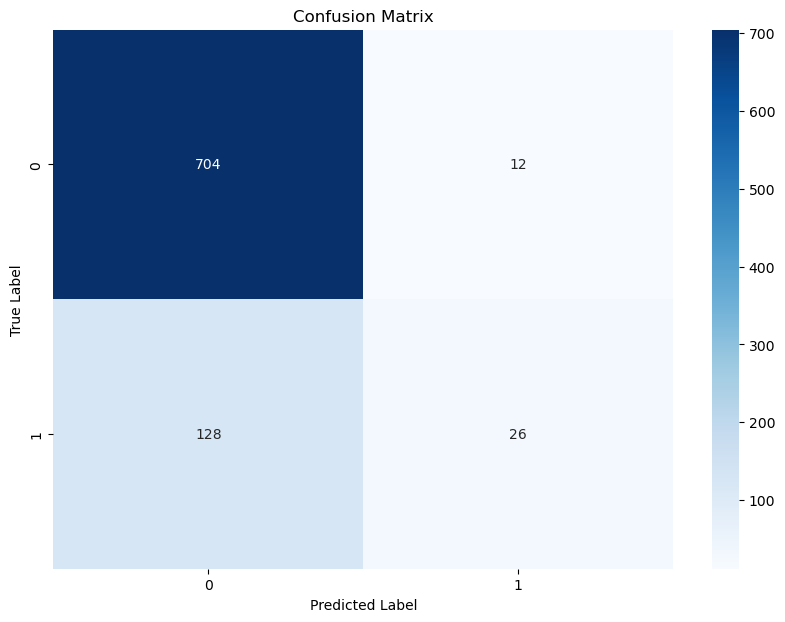

Correctly classified samples per class:
{0: np.int64(704), 1: np.int64(26)}


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: True labels and predictions (replace with your own lists)
# y_true = [...]  # actual labels
# y_pred = [...]  # predicted labels


# Step 2: Define all possible class labels in fixed order
class_labels = [0,1]

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Step 4: Create DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Step 5: Plot as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 6: Get correctly classified counts
correctly_classified = dict(zip(class_labels, cm.diagonal()))
print("Correctly classified samples per class:")
print(correctly_classified)